In [1]:
import numpy as np
import librosa
import librosa.display

from IPython.display import display
from IPython.display import Audio

import pyroomacoustics as pra
from scipy.io import wavfile

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

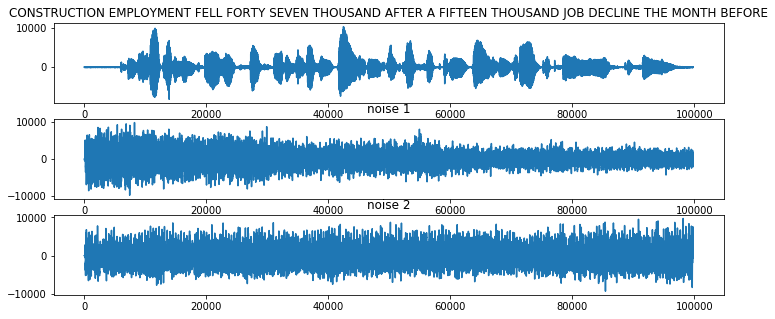

In [2]:
sr, signal = wavfile.read('G:\\speech segregation\\soundly_3rd_seminar-master\\soundly_3rd_seminar-master\\samples\\F01_050C0103_BTH.CH5.wav')
_, noise1 = wavfile.read('G:\\speech segregation\\soundly_3rd_seminar-master\\soundly_3rd_seminar-master\\samples\\BGD_STR_trimmed.wav')
_, noise2 = wavfile.read('G:\\speech segregation\\soundly_3rd_seminar-master\\soundly_3rd_seminar-master\\samples\\BGD_BUS_trimmed.wav')

# convert from int16 to float (-1,1) range
# convert_16_bit = float(2 ** 15)    
# signal = signal / (convert_16_bit + 1.0)
# noise1 = noise1 / (convert_16_bit + 1.0)
# noise2 = noise2 / (convert_16_bit + 1.0)

noise1 = noise1[:len(signal)]
noise2 = noise2[:len(signal)]




plt.subplot(3,1,1)
plt.plot(signal)
plt.title('CONSTRUCTION EMPLOYMENT FELL FORTY SEVEN THOUSAND \
AFTER A FIFTEEN THOUSAND JOB DECLINE THE MONTH BEFORE')
plt.subplot(3,1,2)
plt.plot(noise1)
plt.title('noise 1')
plt.subplot(3,1,3)
plt.plot(noise2)
plt.title('noise 2')

fig = plt.gcf()
fig.set_size_inches(12,5)

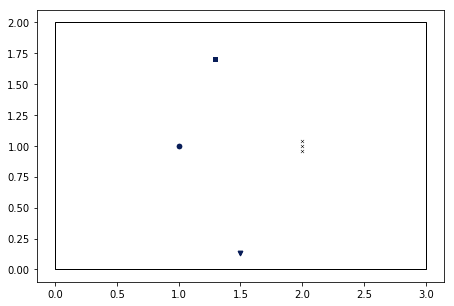

In [3]:
fs = sr
nmic = 3

corners = np.array([[0,0], [0,2], [3,2], [3,0]]).T  # [x,y]

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs, max_order=1, absorption=1.0)

room.add_source([1.,1.], signal=signal)
room.add_source([2-np.cos(np.pi/4) ,1+np.sin(np.pi/4)], signal=noise1)
room.add_source([2-np.cos(np.pi/3) ,1-np.sin(np.pi/3)], signal=noise2)

R = pra.linear_2D_array(center=[2.,1.], M=nmic, phi=0.5*np.pi, d=0.04)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
fig.set_size_inches(12,5)

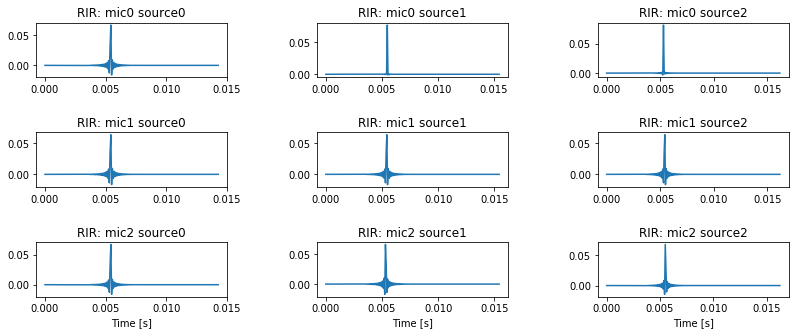

In [4]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(12,5)

In [5]:
# the extra arguments are given in a dictionary
callback_mix_kwargs = {
        'snr' : 100,  # SNR target is 30 decibels
        'sir' : 5,  # SIR target is 10 decibels
        'n_src' : 3,
        'n_tgt' : 1,
        'ref_mic' : 1,
        }

def callback_mix(premix, snr=0, sir=0, ref_mic=0, n_src=None, n_tgt=None):

    # first normalize all separate recording to have unit power at microphone one
    p_mic_ref = np.std(premix[:,ref_mic,:], axis=1)
    premix /= p_mic_ref[:,None,None]

    # now compute the power of interference signal needed to achieve desired SIR
    sigma_i = np.sqrt(10 ** (- sir / 10) / (n_src - n_tgt))
    premix[n_tgt:n_src,:,:] *= sigma_i

    # compute noise variance
    sigma_n = np.sqrt(10 ** (- snr / 10))

    # Mix down the recorded signals
    mix = np.sum(premix[:n_src,:], axis=0) + sigma_n * np.random.randn(*premix.shape[1:])

    return mix

# Run the simulation
room.simulate(
        callback_mix=callback_mix,
        callback_mix_kwargs=callback_mix_kwargs,
        )

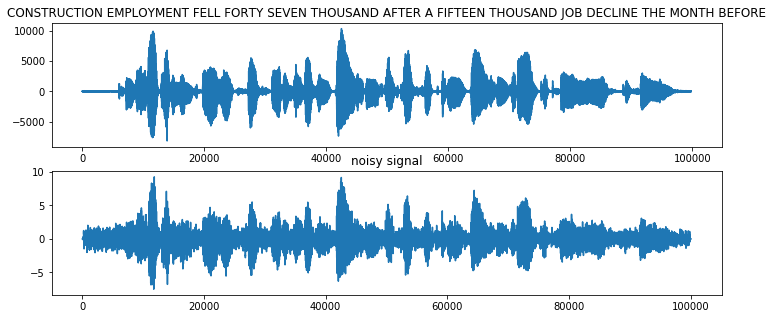

In [8]:
mic_signals = room.mic_array.signals

plt.subplot(2,1,1)
plt.plot(signal)
plt.title('CONSTRUCTION EMPLOYMENT FELL FORTY SEVEN THOUSAND \
AFTER A FIFTEEN THOUSAND JOB DECLINE THE MONTH BEFORE')
plt.subplot(2,1,2)
plt.plot(mic_signals[1,:])
plt.title('noisy signal')

#plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(12,5)

display(Audio(signal, rate=sr))
display(Audio(mic_signals[1,:], rate=sr))

In [7]:
display(Audio(signal, rate=sr))
display(Audio(mic_signals[1,:], rate=sr))